In [1]:
import os
import sys
threads_num = 2
os.environ["MKL_NUM_THREADS"] = f"{threads_num}" 
os.environ["NUMEXPR_NUM_THREADS"] = f"{threads_num}"
os.environ["OMP_NUM_THREADS"] = f"{threads_num}"
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
import numpy as np
import pandas as pd
import warnings

from utils import colors, sample_type_to_color, sample_type_to_label, export_legend, transform_model, merge_vdj_alleles, full_js_distance, full_shannon_entropy, draw_distances, get_distance_stats_test, draw_pvalues

sns.set_style("ticks")

In [2]:
DATA_DIR = "../data/antigen_specific_pgens"
FIGURES_DIR = "../figures/figure_4/"

In [3]:
combined_df = pd.read_csv(os.path.join(DATA_DIR, "antigen_specific_trimmed.csv"))

In [4]:
combined_df = combined_df.drop_duplicates()
display(combined_df.antigen.value_counts())
print(f"total: {combined_df.shape[0]}")

SARS-CoV2              1062
TG2                    1048
HIV                     324
SARS-CoV1,SARS-CoV2     304
Tetanus                 290
Influenza               283
MERS-CoV                 97
SARS-CoV1                84
Name: antigen, dtype: int64

total: 3492


# rubelt nat comm

In [5]:
inds = ["pair_1_twin_A", "pair_1_twin_A_data_replicate", "pair_1_twin_B", "pair_2_twin_A"]
prefix = os.path.join(DATA_DIR, "outputs/")
pgens = [pd.read_csv(os.path.join(prefix, f"{ind}.csv"), header=None).loc[combined_df.index].rename({0: "aaseq", 1:"pgen"}, axis=1) \
             for ind in inds]

In [6]:
eps = 1e-36
pgen_df = pd.concat([p.pgen for p in pgens], axis=1)
pgen_df.columns = inds
pgen_df = pgen_df.applymap(lambda s: max(s, eps))

pgen_df["antigen"] = combined_df["antigen"]
pgen_df

,pair_1_twin_A,pair_1_twin_A_data_replicate,pair_1_twin_B,pair_2_twin_A,antigen
0,3.896774e-15,4.369455e-15,8.339618e-14,3.165829e-14,SARS-CoV2
1,4.312351e-19,6.402037e-19,5.146480e-16,7.815846e-15,SARS-CoV2
2,6.374011e-24,4.117507e-24,2.132311e-24,3.968543e-24,SARS-CoV2
3,6.907630e-10,6.797577e-10,1.664470e-10,2.958362e-11,SARS-CoV2
4,4.561027e-16,3.797267e-16,1.171342e-15,4.625740e-15,SARS-CoV2
...,...,...,...,...,...
6821,1.740602e-23,1.261984e-23,2.268452e-24,9.057162e-24,TG2
6822,1.153689e-11,9.888379e-12,1.878346e-11,7.717772e-12,TG2
6823,1.509747e-15,1.296259e-15,3.034869e-15,5.397634e-16,TG2
6824,7.180597e-14,5.861064e-14,1.395574e-14,2.081884e-14,TG2


In [7]:
antigens = list(pgen_df.antigen.value_counts().index)
antigens

['SARS-CoV2',
 'TG2',
 'HIV',
 'SARS-CoV1,SARS-CoV2',
 'Tetanus',
 'Influenza',
 'MERS-CoV',
 'SARS-CoV1']

In [8]:
seqs_by_antigen = combined_df.antigen.value_counts()
max_seqs_by_antigen = seqs_by_antigen.max()
max_seqs_by_antigen

1062

In [9]:
seqs_by_antigen

SARS-CoV2              1062
TG2                    1048
HIV                     324
SARS-CoV1,SARS-CoV2     304
Tetanus                 290
Influenza               283
MERS-CoV                 97
SARS-CoV1                84
Name: antigen, dtype: int64

In [10]:
seqs_by_antigen["SARS-CoV1,2"] = seqs_by_antigen["SARS-CoV1,SARS-CoV2"]

In [11]:
def absolute_ratio(v1, v2):
    return np.max([v1, v2], axis=0) / np.min([v1, v2], axis=0)

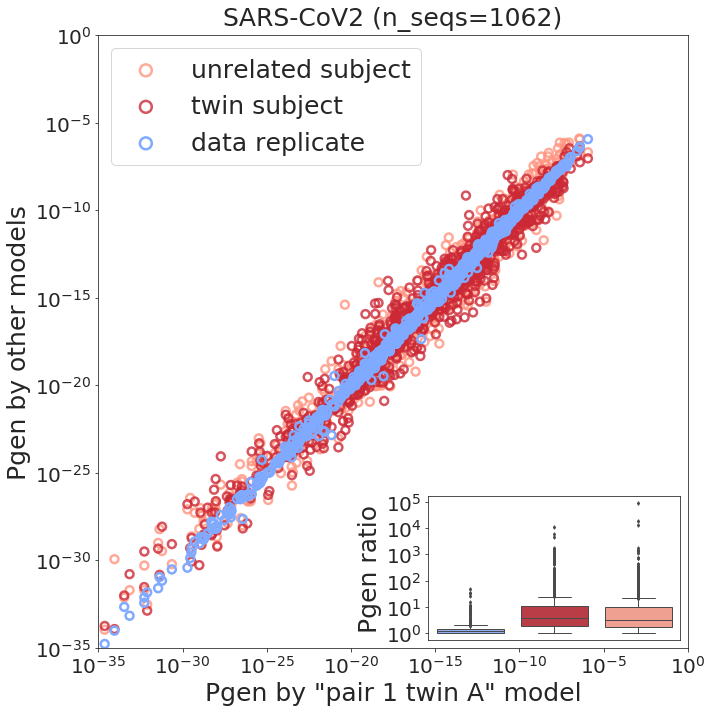

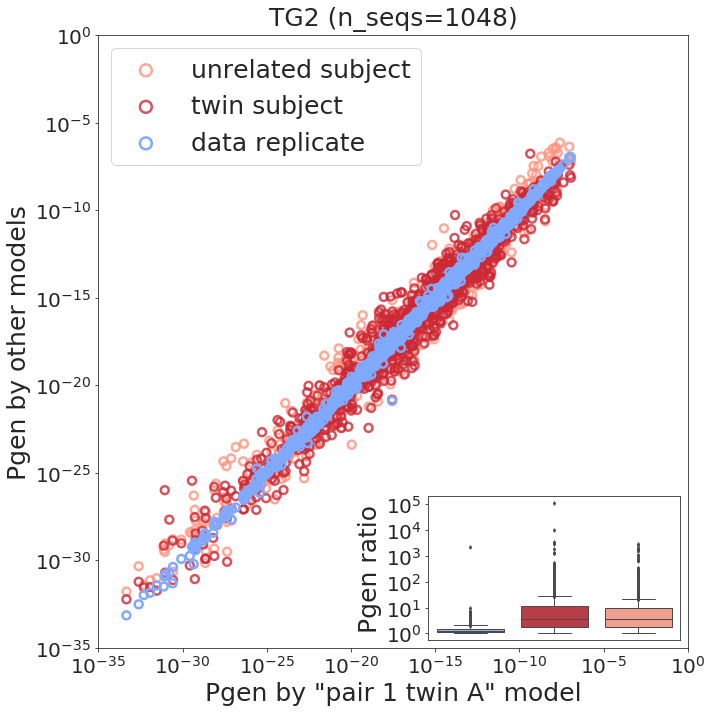

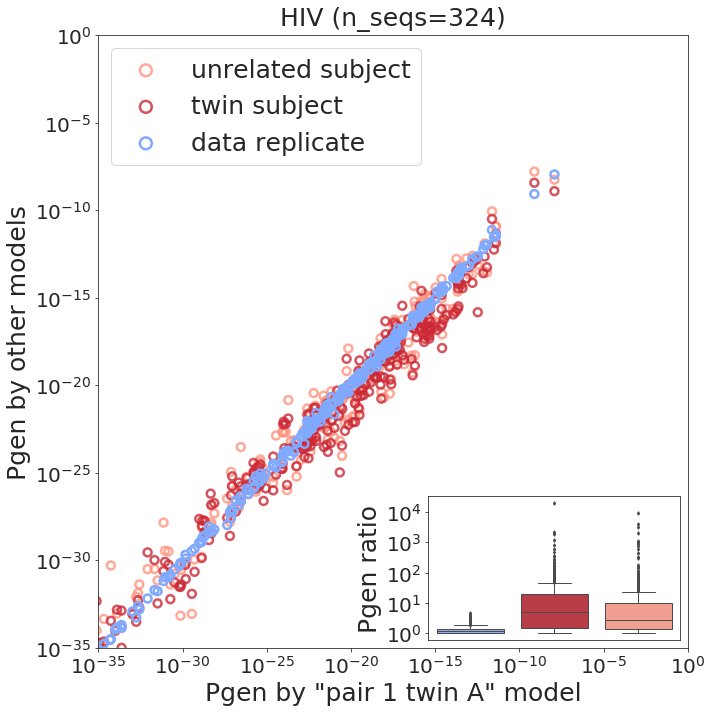

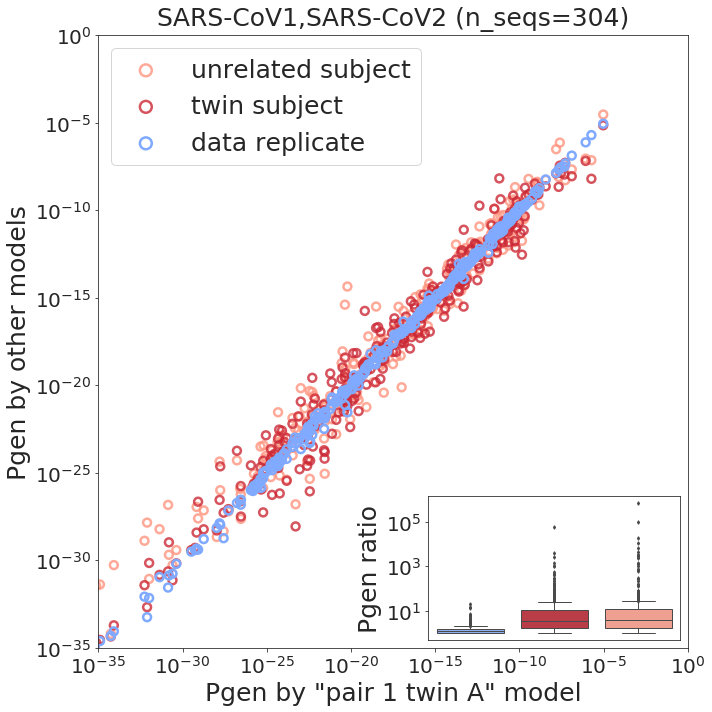

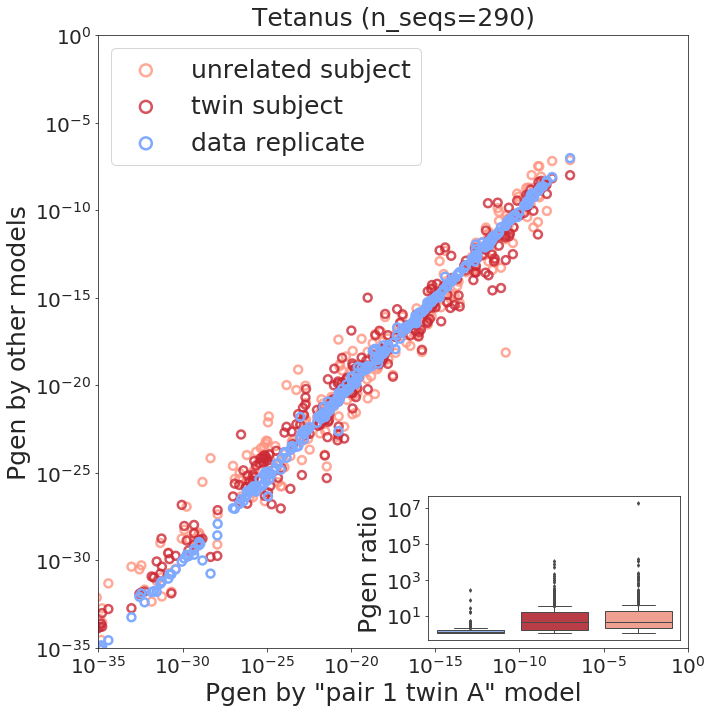

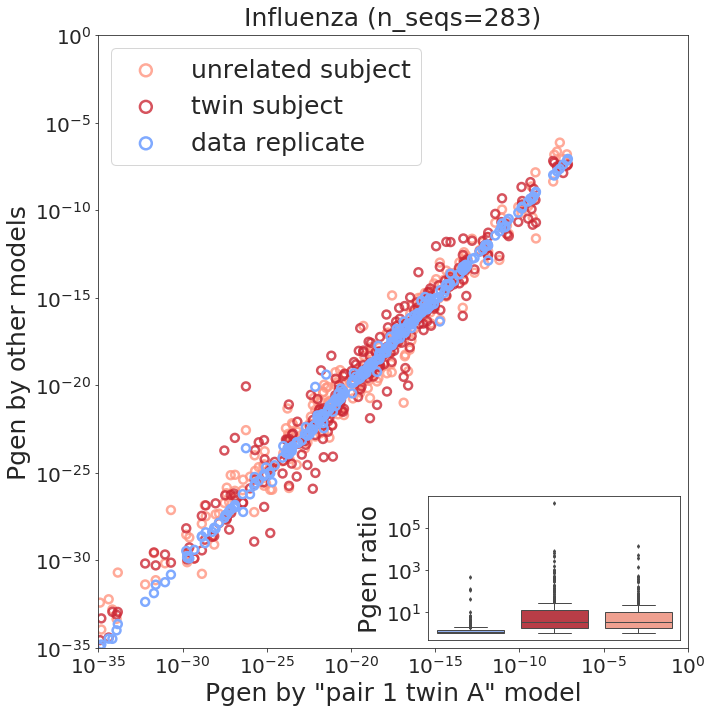

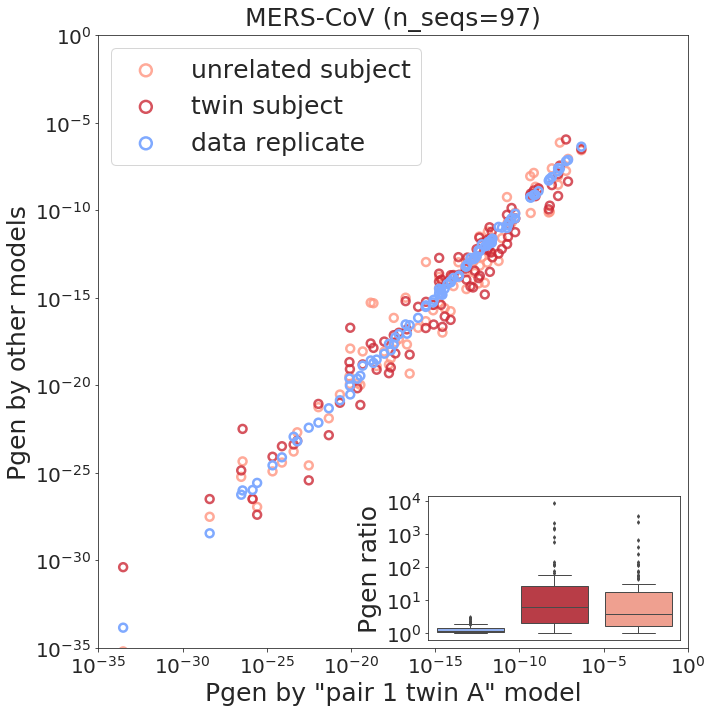

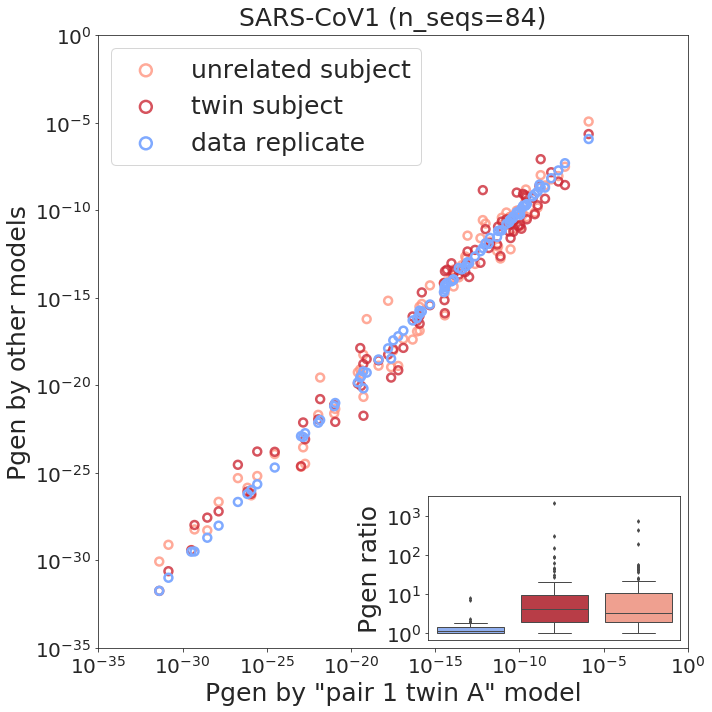

In [12]:
warnings.filterwarnings('ignore')
for antigen in antigens:
    
    current_pgen_df = pgen_df.loc[pgen_df.antigen == antigen]

    fig = plt.figure(figsize=(10, 10))

    fontsize=25

    alpha=0.8
    linewidth=2.5
    plt.scatter(current_pgen_df[inds[0]], current_pgen_df[inds[3]], s=fontsize * 2.5, linewidth=linewidth,
                edgecolors=sample_type_to_color["unrelated"], alpha=alpha, facecolors="none", label="unrelated subject")
    plt.scatter(current_pgen_df[inds[0]], current_pgen_df[inds[2]], s=fontsize * 2.5, linewidth=linewidth,
                edgecolors=sample_type_to_color["twins"], alpha=alpha, facecolors="none", label="twin subject")
    plt.scatter(current_pgen_df[inds[0]], current_pgen_df[inds[1]], s=fontsize * 2.5, linewidth=linewidth,
                edgecolors=sample_type_to_color["data"], alpha=1, facecolors="none", label="data replicate")

    plt.xscale("log")
    plt.yscale("log")


    plt.xlim((1e-35, 1))
    plt.ylim((1e-35, 1))


    plt.legend(fontsize=fontsize, markerscale=1.5, loc="upper left")
    plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize * 0.8)
    plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.8)
    plt.minorticks_off()
    
    
    plt.xlabel("Pgen by \"" + inds[0].replace("_", " ") + "\" model", fontsize=fontsize)
    plt.ylabel("Pgen by other models", fontsize=fontsize)
    
    plt.title(f"{antigen} (n_seqs={seqs_by_antigen[antigen]})", fontsize=fontsize, pad=10.0)
    
    ax2 = fig.add_axes([0.6, 0.105, 0.35, 0.2])
    
    data_replicate_ratios = absolute_ratio(current_pgen_df[inds[0]], current_pgen_df[inds[1]])
    twin_ratios = absolute_ratio(current_pgen_df[inds[0]], current_pgen_df[inds[2]])
    unrelated_ratios = absolute_ratio(current_pgen_df[inds[0]], current_pgen_df[inds[3]])
    all_ratios = np.concatenate([data_replicate_ratios, twin_ratios, unrelated_ratios])
    hues = np.repeat(["data replicate", "twin subject", "unrelated subject"], repeats=current_pgen_df.shape[0])
    hue = "Sample type"
    y = "Pgen ratio"
    long_df = pd.DataFrame(np.array([all_ratios, hues]).T, columns=[y, hue])
    long_df[y] = long_df[y].astype(np.float64)
    sns.boxplot(data=long_df, x=hue, y=y,
                palette=[sample_type_to_color["data"],
                         sample_type_to_color["twins"],
                         sample_type_to_color["unrelated"]],
                fliersize=2.5,
                linewidth=1,
                ax=ax2)
    ax2.set_yscale("log")

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.8)
    plt.ylabel("Pgen ratio", fontsize=fontsize)
    plt.xlabel("", fontsize=fontsize)
    plt.minorticks_off()

    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"rubelt_{antigen}.png"), format="png")
    plt.show()
    
    
    

# gidoni nat comm

In [13]:
fs = os.listdir(os.path.join(DATA_DIR, "gidoni_outputs/"))
inds = [int(s[1:].split('.')[0]) for s in fs]

In [14]:
inds = [f"S{i}" for i in range(1, 101) if i in inds]
prefix = os.path.join(DATA_DIR, "gidoni_outputs/")
gidoni_pgens = [pd.read_csv(os.path.join(prefix, f"{ind}.csv"), header=None).loc[combined_df.index].rename({0: "aaseq", 1:"pgen"}, axis=1) \
             for ind in inds]

In [15]:
eps = 1e-35
gidoni_pgen_df = pd.concat([p.pgen for p in gidoni_pgens], axis=1)
gidoni_pgen_df.columns = inds
gidoni_pgen_df = gidoni_pgen_df.applymap(lambda s: max(s, eps))
gidoni_pgen_df["antigen"] = combined_df["antigen"]

In [16]:
median = np.median(gidoni_pgen_df.iloc[:, :-1], axis=1)
q5 = np.quantile(gidoni_pgen_df.iloc[:, :-1], q=0.05, axis=1)
q25 = np.quantile(gidoni_pgen_df.iloc[:, :-1], q=0.25, axis=1)
q75 = np.quantile(gidoni_pgen_df.iloc[:, :-1], q=0.75, axis=1)
q95 = np.quantile(gidoni_pgen_df.iloc[:, :-1], q=0.95, axis=1)

In [17]:
gidoni_pgen_df.loc[gidoni_pgen_df.antigen == "SARS-CoV1,SARS-CoV2", "antigen"] = "SARS-CoV1,2"

In [18]:
gidoni_pgen_df["median"] = median
gidoni_pgen_df["q5"] = q5
gidoni_pgen_df["q25"] = q25
gidoni_pgen_df["q75"] = q75
gidoni_pgen_df["q95"] = q95

In [19]:
gidoni_pgen_df.sort_values(by=["antigen", "median", "q75", "q25", "q95", "q5"], inplace=True)
gidoni_pgen_df.reset_index(drop=True, inplace=True)

In [20]:
antigens = gidoni_pgen_df.antigen.drop_duplicates()

In [21]:
threshold_1 = 10**-16
threshold_2 = 10**-8

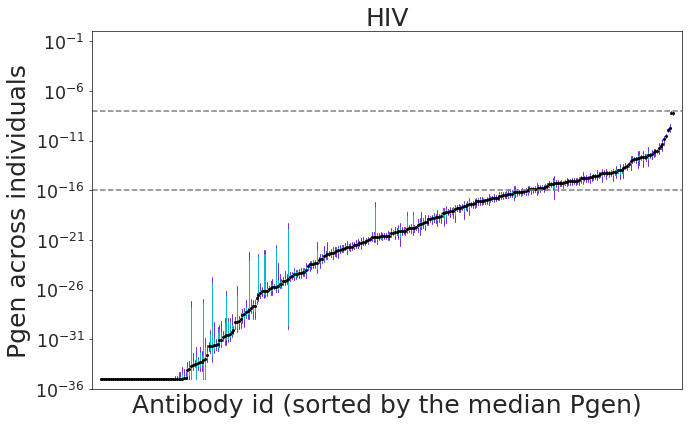

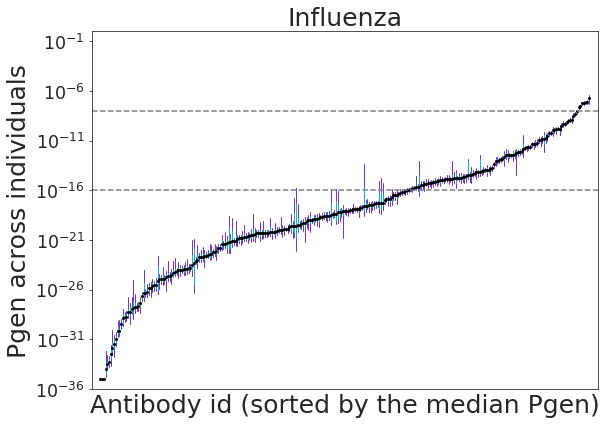

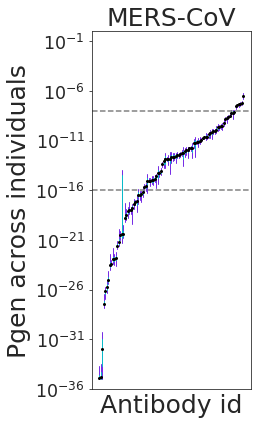

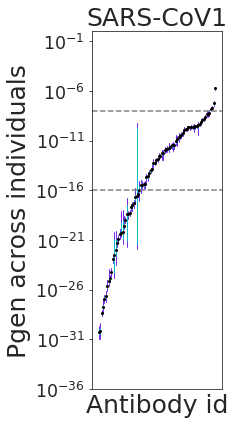

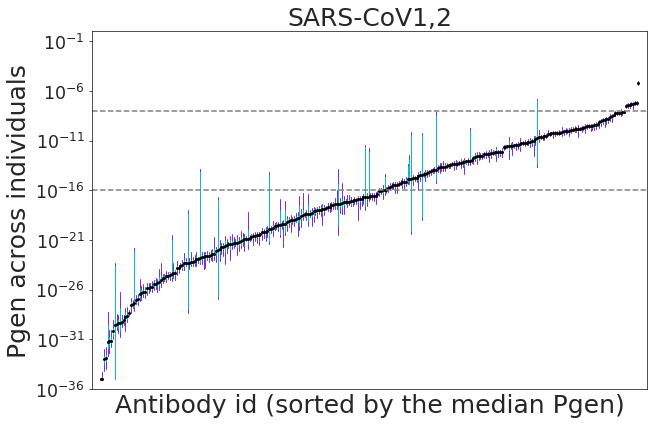

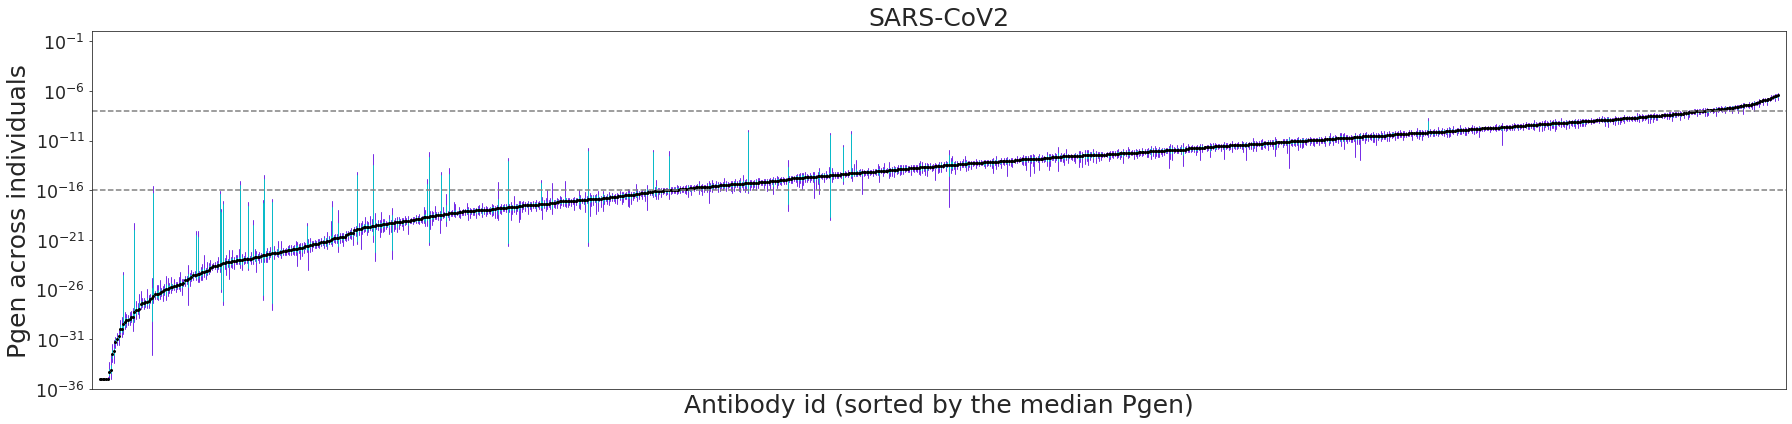

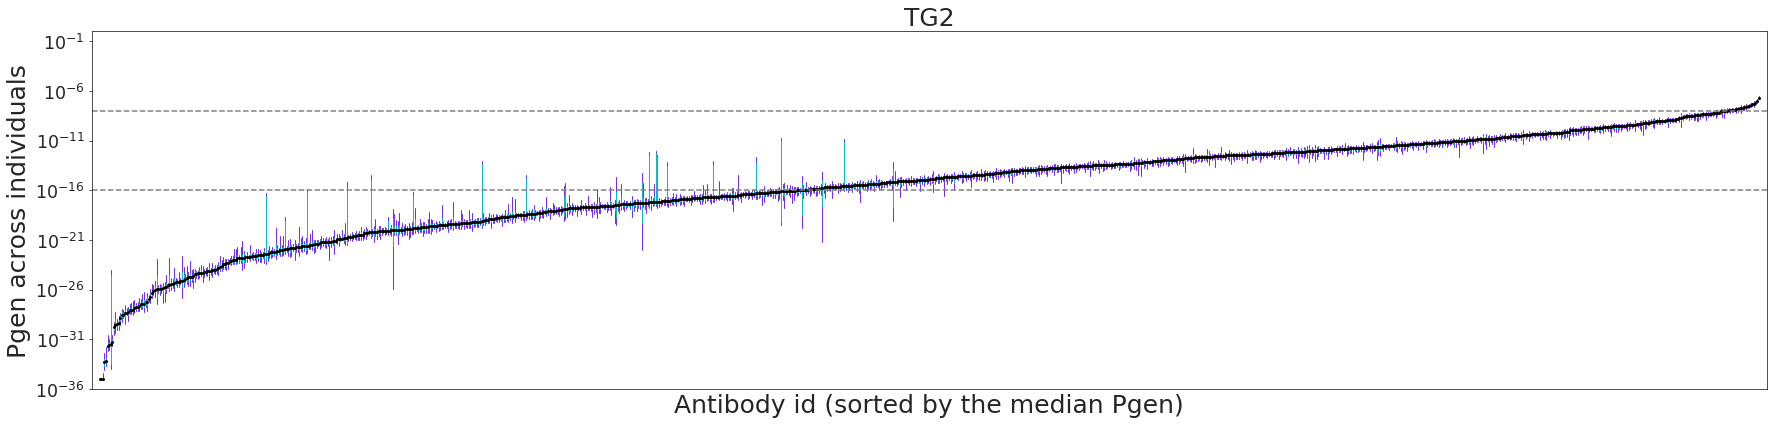

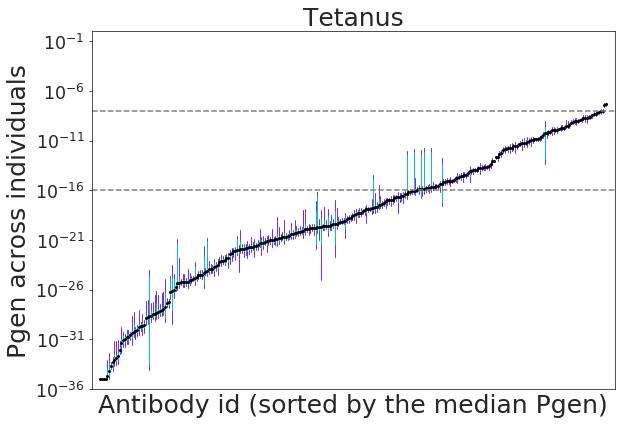

In [22]:
fontsize=25


color_1 = mpl.colors.hex2color("#0ABAC9")
color_2 = mpl.colors.hex2color("#772EE6")

offset = 0
xlabel_positions = []
add_label = True
for antigen in antigens:
    
    seqs_for_current_antigen = seqs_by_antigen[antigen]
    figsize = (25 * (seqs_for_current_antigen / max_seqs_by_antigen)**0.8, 6)
    plt.figure(figsize=figsize)
    current_df = gidoni_pgen_df.loc[gidoni_pgen_df.antigen == antigen]
    xs = current_df.index.to_numpy()
    linewidth=1
    
    linestyle='None'
    marker='o'
    markersize = 2
    , markersize=markersize
    for i in range(xs.shape[0]):
        x = xs[i]
        plt.plot([x, x], [current_df["q5"].iloc[i], current_df["q95"].iloc[i]], color=color_2, linewidth=linewidth)
    for i in range(xs.shape[0]):
        x = xs[i]
        plt.plot([x, x], [current_df["q25"].iloc[i], current_df["q75"].iloc[i]], color=color_1, linewidth=linewidth)
    
    plt.plot(xs, current_df["median"].to_numpy(), marker=marker, color="black", linestyle=linestyle, label="median" if add_label else None, linewidth=linewidth, markersize=markersize)
    plt.axhline(threshold_1, linestyle='--', color="grey")
    plt.axhline(threshold_2, linestyle='--', color="grey")
    
    
        

    plt.yscale("log")


    plt.ylim((eps / 10, 10**0))
    plt.xlim((xs.min() - 5, xs.max() + 5))


    plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize * 0.7)
    plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.7)

    plt.tick_params(axis='x',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False)
    plt.minorticks_off()

    plt.title(antigen, fontsize=fontsize)
    plt.xlabel("Antibody id" + (" (sorted by the median Pgen)" if figsize[0] > 5 else ""), fontsize=fontsize)
    plt.ylabel("Pgen across individuals", fontsize=fontsize)


    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"gidoni_percentiles_{antigen}.png"), format="png")
    plt.show()

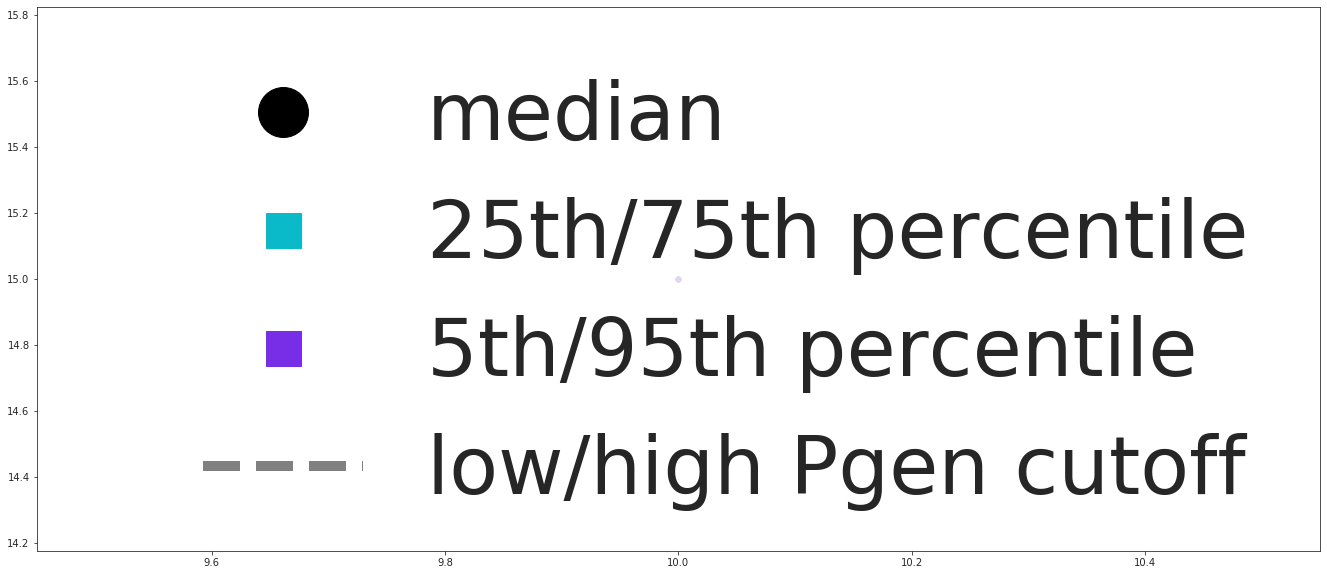

In [23]:
fig = plt.figure(figsize=(23, 10))
fontsize = 25
x = [10, 10]
y = [15, 15]

plt.plot(x, y, color="black", marker=marker, markersize=5, linestyle=linestyle, label="median", linewidth=linewidth)
plt.plot(x, y, color=color_1, marker='s', markersize=3.5, linestyle=linestyle, label="25th/75th percentile", linewidth=linewidth)
plt.plot(x, y, color=color_2, marker='s', markersize=3.5, linestyle=linestyle, label="5th/95th percentile", linewidth=linewidth)
plt.plot(x, y, color="grey", linestyle="--", label="low/high Pgen cutoff", linewidth=linewidth)

    
sc_coef = 4
leg = plt.legend(fontsize=fontsize * 0.8 * sc_coef, markerscale=2.5 * sc_coef)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.5 * sc_coef)
export_legend(leg, filename=os.path.join(FIGURES_DIR, "legend.png"))
plt.show()

In [24]:
n_seqs_by_antigen = gidoni_pgen_df.antigen.value_counts()

In [25]:
all_diffs = []
all_antigens = []
all_groups = []
for i, row in enumerate(gidoni_pgen_df.iloc[:, :-6].values):
    diffs = [max(row[i], row[k]) / min(row[i], row[k]) \
     for i in range(row.shape[0]) \
         for k in range(i+1, row.shape[0]) if row[i] > eps or row[k] > eps]
    antigen = gidoni_pgen_df.antigen[i]
    antigens = [f"{antigen} (n_seqs={n_seqs_by_antigen[antigen]})"] * len(diffs)
    current_median = gidoni_pgen_df["median"].iloc[i]
    if current_median < threshold_1:
        group = "low"
    elif current_median >= threshold_1 and current_median < threshold_2:
        group = "medium"
    else:
        group = "high"
    current_groups = [group] * len(diffs)
    all_diffs.append(diffs)
    all_antigens.append(antigens)
    all_groups.append(current_groups)

In [26]:
all_diffs = np.concatenate(all_diffs)
all_antigens = np.concatenate(all_antigens)
all_groups = np.concatenate(all_groups)
long_df = pd.DataFrame(np.array([all_diffs, all_antigens, all_groups]).T, columns=["pgen difference", "antigen", "group"])

In [27]:
sampled_df = long_df.groupby("antigen").apply(lambda df: df.sample(df.shape[0] // 100, axis=0, replace=False)).reset_index(drop=True)

In [28]:
sampled_df["pgen difference"] = sampled_df["pgen difference"].astype(np.float64)

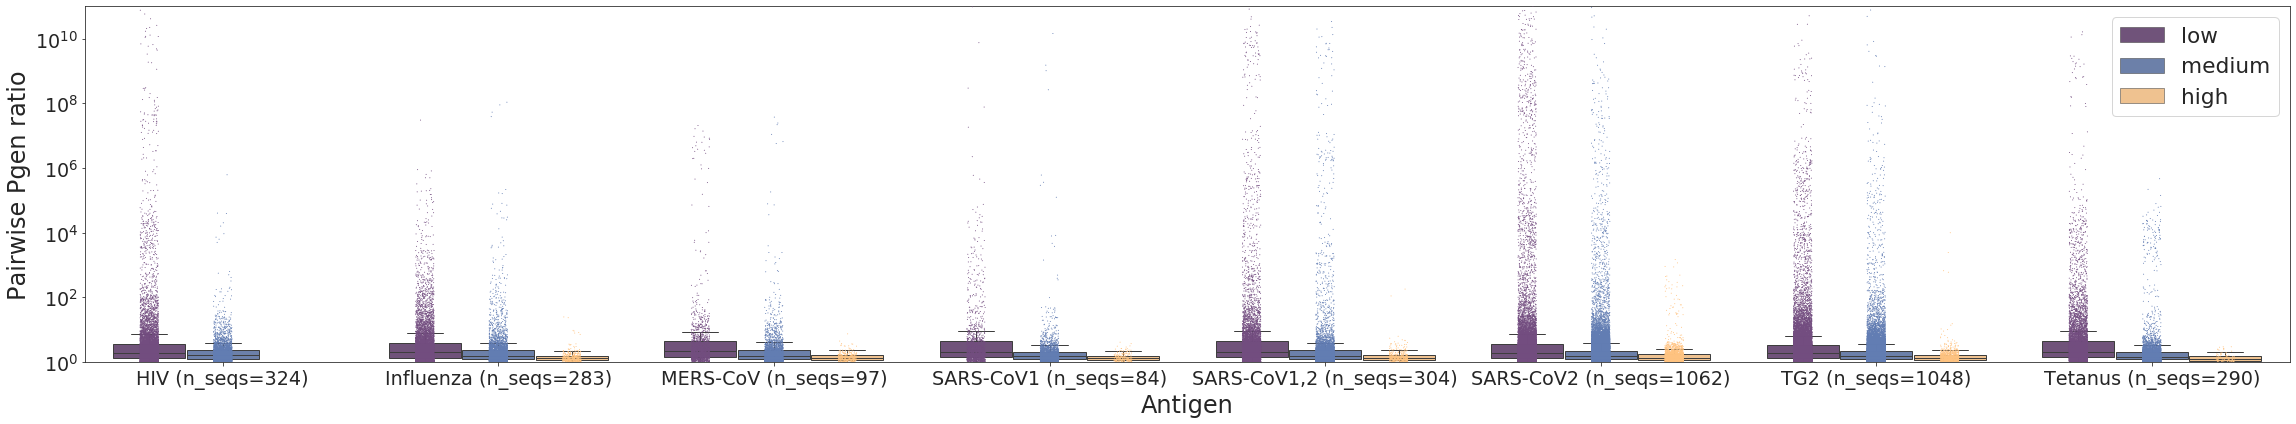

In [29]:
plt.figure(figsize=(32, 6))

fontsize=24

color_low = mpl.colors.hex2color("#734d80")
color_medium = mpl.colors.hex2color("#627db3")
color_high = mpl.colors.hex2color("#FFC380")

palette = [color_low, color_medium, color_high]
sns.boxplot(data=sampled_df, x="antigen", y="pgen difference", linewidth=1, hue="group", palette=palette, fliersize=0, hue_order=["low", "medium", "high"])
sns.stripplot(data=sampled_df, x="antigen", y="pgen difference", hue="group", dodge=True, palette=palette, size=1, hue_order=["low", "medium", "high"])


plt.setp(plt.gca().get_xticklabels(), fontsize=fontsize * 0.8)
plt.setp(plt.gca().get_yticklabels(), fontsize=fontsize * 0.8)
plt.yscale("log")

plt.xlabel("Antigen", fontsize=fontsize)
plt.ylabel("Pairwise Pgen ratio", fontsize=fontsize)

leg = plt.legend(fontsize=fontsize)
leg.legendHandles = leg.legendHandles[:3]
plt.legend(leg.legendHandles, ["low", "medium", "high"],
           fontsize=fontsize * 0.9, loc="best")

plt.ylim((10**0, 10**11))

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f"gidoni_boxplots.png"), format="png")
plt.show()

In [30]:
GIDONI_DATA_DIR = "../data/gidoni_nat_comm/"
df_id_to_sample = pd.read_csv(
    GIDONI_DATA_DIR + "/samp_key_21_10.tab", sep='\t')
df_sample_to_status = pd.read_csv(GIDONI_DATA_DIR + "/celiac_100_clin.tab", sep='\t')
df_sample_to_status["Subject "] = df_sample_to_status["Subject "].map(lambda s: s.replace("-", "_").replace("(", "").replace(")", "").replace(" ", "_"))
df_sample_to_status = df_sample_to_status.set_index("Subject ").TYPE.to_dict()
id_to_status = [df_sample_to_status[df_id_to_sample["SUBJECT"][i]] if df_id_to_sample["SUBJECT"][i] in df_sample_to_status else "Unknown" for i in range(100)]

In [31]:
tg2_pgens = gidoni_pgen_df.loc[gidoni_pgen_df.antigen == "TG2"].iloc[-200:, :99].to_numpy()
tg2_pgens.shape

(200, 99)

In [32]:
status = [id_to_status[i-1] for i in list(range(1, 97)) + list(range(98, 101))]
status = np.tile(status, tg2_pgens.shape[0])
subject = np.tile(gidoni_pgen_df.iloc[:, :99].columns, tg2_pgens.shape[0])
antibody_id = np.repeat(np.arange(tg2_pgens.shape[0]), tg2_pgens.shape[1])

In [33]:
df = pd.DataFrame(np.array([tg2_pgens.flatten(), status, subject, antibody_id]).T, columns=["pgen", "status", "subject", "antibody"])

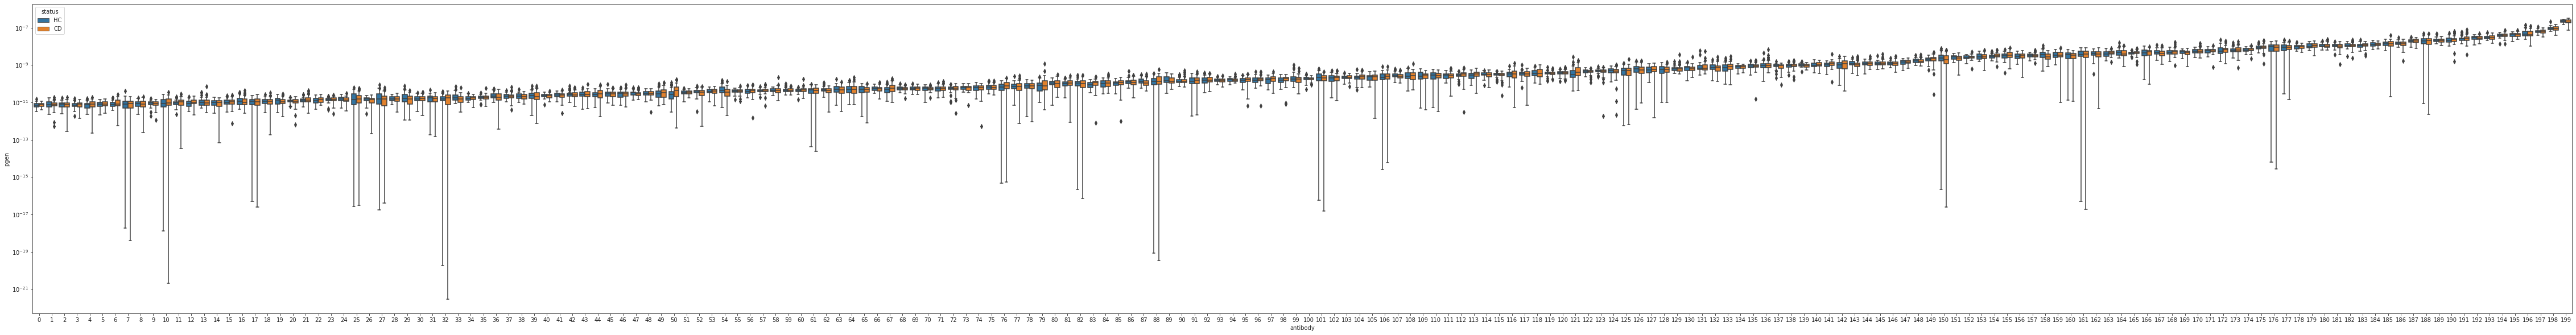

In [34]:
plt.figure(figsize=(80, 10))


sns.boxplot(data=df, y="pgen", x="antibody", hue="status", dodge=True)
plt.yscale("log")

plt.show()